In [1]:
import pandas as pd #Для работы с таблицами данных (дата фреймы)
import requests #Для запросов к серверу
import json #Для обработки ответов сервера
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import apimoex
import requests
import yfinance as yf

In [2]:
#функция для того, чтобы брать цену тикера на какой-либо день
import apimoex
import requests
def ticker(ticker_name, start, end):
    with requests.Session() as session:
        data = pd.DataFrame()
        boards = ['EQBR', 'EQBS', 'EQCC', 'EQDE', 'EQDP', 'EQLI', 'EQLV', 'EQNE', 'EQNL', 'EQTD', 'EQTU', 'SMAL', 'SPEQ', 'TQBE', 'TQBR', 'TQBS', 'TQDE', 'TQDP', 'TQFD', 'TQFE', 'TQIF', 'TQLI', 'TQLV', 'TQNE', 'TQNL', 'TQPD', 'TQPE', 'TQPH', 'TQPI', 'TQPY', 'TQTD', 'TQTE', 'TQTF', 'TQTH', 'TQTY']
        for key in boards:
            data = data.append(apimoex.get_board_history(session = session,
                                                      board = key,
                                                  security = ticker_name,
                                                  start = start,
                                                  end = end))
    data['Names'] = [ticker_name] * data.shape[0]
    return(data)

In [3]:
def yf_stocks(companies, start, end):
    df_stocks = yf.download(companies, start=start, end=end)['Adj Close']
    return(df_stocks)

In [4]:
#функция, чтобы считать доходность и волатильность портфеля за определенный период
def portfolio_metrics(df, start_date, end_date, weights):
    # select the rows for the specified period
    df_period = df.loc[start_date:end_date]

    # calculate the daily returns
    daily_returns = df_period.pct_change()

    # calculate the portfolio returns
    portfolio_returns = (daily_returns * weights).sum(axis=1)

    # calculate the annualized return
    annual_return = (1 + portfolio_returns.mean()) ** 252 - 1

    # calculate the annualized volatility
    annual_volatility = np.sqrt(252) * portfolio_returns.std()

    # calculate the Sharpe ratio
    risk_free_rate = 0.03 # assuming a risk-free rate of 3%
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    return annual_return, annual_volatility, sharpe_ratio

In [5]:
import numpy as np
import pandas as pd
import arch

def portfolio_metrics_arch(df, start_date, end_date, weights):
    # select the rows for the specified period
    df_period = df.loc[start_date:end_date]

    # calculate the daily returns
    daily_returns = df_period.pct_change()

    # calculate the portfolio returns
    portfolio_returns = (daily_returns * weights).sum(axis=1)

    # estimate the volatility using a GARCH(1,1) model
    model = arch.arch_model(portfolio_returns, mean='Zero', vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')
    annual_volatility = np.sqrt(252) * results.conditional_volatility[-1]

    # calculate the annualized return
    annual_return = (1 + portfolio_returns.mean()) ** 252 - 1

    # calculate the Sharpe ratio
    risk_free_rate = 0.03 # assuming a risk-free rate of 3%
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    return annual_return, annual_volatility, sharpe_ratio

In [6]:
#функция, чтобы выбирать рандомно числа для монте-карло
def get_random_date_range(df, min_range=360, max_range=1800):
    """
    Generates a random date range for a given dataframe.

    Parameters:
    - df: pandas dataframe containing date index
    - min_range: minimum range of days between start and end dates (default = 360)
    - max_range: maximum range of days between start and end dates (default = 1800)

    Returns:
    - tuple containing (start_date, end_date, days_between)
    """
    # Determine the valid range of dates based on min_range and max_range
    valid_dates = df.index[df.index <= len(df) - min_range]
    max_start_date = df.index[len(valid_dates)] if len(valid_dates) > 0 else df.index[0]
    max_end_date = max_start_date + max_range

    # Choose a random start date within the valid range
    start_date = df.index[random.choice(valid_dates)]

    # Choose a random end date within the valid range
    end_date = random.choice(df.loc[start_date:max_end_date].index)

    # Compute the number of days between the start and end dates
    days_between = (end_date - start_date)

    # Check if the difference between start and end date is within the given range
    while days_between > max_range or days_between < min_range:
        end_date = random.choice(df.loc[start_date:max_end_date].index)
        days_between = (end_date - start_date)

    # Return the selected date range and the number of days between them as a tuple
    return (start_date, end_date, days_between)

In [47]:
def finding_weights(companies, start, end):
    df_new = yf_stocks(companies, start=start, end=end)
    df_intermediate = df_new.copy()
    df_intermediate = df_intermediate.dropna(thresh=0.8*len(df_intermediate.index), axis='columns')
    df_intermediate.fillna(method='ffill', inplace=True)
    
    column_names = df_intermediate.columns.tolist()
    log_returns = np.log(df_intermediate).diff()
    # calculate the volatility for each share
    volatility = log_returns.std()
    weights = volatility.rank().apply(lambda x: 1/x)
    weights /= weights.sum()
    weights = weights.fillna(0)  # replace NaN values with 0
    return (column_names, weights)

In [8]:
def getting_retur_volat(companies, weights, start, end):
    #df_new = pd.DataFrame()
    #for item in companies:
        #df_new = df_new.append(ticker(item, start = start, end = end))
    df_new = yf_stocks(companies, start = start, end = end) 
    
    df_new = df_new.dropna( thresh = 0.8*len(df_new.index) , axis='columns') #выкидывает колонки, где пропущенные значения больше 80%
    df_new.fillna(method='ffill', inplace=True)
    metrics = portfolio_metrics(df_new,  start_date= start, end_date = end, weights = weights)
    return(metrics)

In [9]:
#Get a 14 lists of a companies
n = 14 #years 
for i in range(n):
    filename = f"D:/Jupyter notebook/files/НИР/список акций/список акций на { i+2009}.xlsx"
    cap = pd.read_excel(filename)
    globals()[f"companies_{i+2009}"] = list(cap['Торговый код'] + '.ME')

In [48]:
df_weighted = pd.DataFrame(columns=['return', 'volatility'])
for i in range(1,13):
    globals()[f"information_{i+2009}_{(i+1)+2009}"] = finding_weights(companies=globals()[f"companies_{i+2009}"], start=f"{i+2009}-01-01", end=f"{(i+1)+2009}-01-01")
    #print(globals()[f"information_{i+2009}_{(i+1)+2009}"])
    globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"] = getting_retur_volat(globals()[f"information_{i+2009}_{(i+1)+2009}"][0],
                                                                            weights=globals()[f"information_{i+2009}_{(i+1)+2009}"][1], 
                                                                            start=f"{(i+1)+2009}-01-01", end=f"{(i+2)+2009}-01-01")
    #print(globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"])
    df_weighted.loc[f"{2009+i+1}_{2009+i+2}"] = [globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][0],
                                                 globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][1]]

[*********************100%***********************]  239 of 239 completed

139 Failed downloads:
- VZRZ.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- RU0009011126.ME: No timezone found, symbol may be delisted
- VTGK.ME: No timezone found, symbol may be delisted
- PMOT.ME: No timezone found, symbol may be delisted
- OSFD.ME: No timezone found, symbol may be delisted
- YRSL.ME: No timezone found, symbol may be delisted
- NGSB.ME: No timezone found, symbol may be delisted
- RU14PRMB2004.ME: No timezone found, symbol may be delisted
- RU14AVAN8010.ME: No timezone found, symbol may be delisted
- SPTL.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- SOVT.ME: No timezone found, symbol may be delisted
- UDSB.ME: No timezone found, symbol may be delisted
- OGKC.ME: No data found for this date range, symbol may be delisted
- TGKE.ME: No timezone found, symbol may be delisted
- NPE1.ME: No ti

[*********************100%***********************]  114 of 114 completed
[*********************100%***********************]  349 of 349 completed

187 Failed downloads:
- VTGK.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- BNSB.ME: No timezone found, symbol may be delisted
- UFOS.ME: No timezone found, symbol may be delisted
- AGRE.ME: No timezone found, symbol may be delisted
- PMOT.ME: No timezone found, symbol may be delisted
- ERCO.ME: No timezone found, symbol may be delisted
- GAZC.ME: No timezone found, symbol may be delisted
- KUSBP.ME: No timezone found, symbol may be delisted
- PZSB.ME: No timezone found, symbol may be delisted
- BEGY.ME: No timezone found, symbol may be delisted
- MRKH.ME: No data found for this date range, symbol may be delisted
- URKA.ME: No timezone found, symbol may be delisted
- MSSV.ME: No timezone found, symbol may be delisted
- IRSG.ME: No timezone found, symbol may be delisted
- RVST.ME: No timez

D:\python\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  160 of 160 completed
[*********************100%***********************]  294 of 294 completed

121 Failed downloads:
- VZRZ.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- KMTZ.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- VTGK.ME: No timezone found, symbol may be delisted
- YRSL.ME: No timezone found, symbol may be delisted
- TRUDP.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- TGKK.ME: No data found for this date range, symbol may be delisted
- PMOT.ME: No timezone found, symbol may be delisted
- TNBP.ME: No data found for this date range, symbol may be delisted
- TGKE.ME: No timezone found, symbol may be delisted
- ERCO.ME: No timezone found, symbol may be delisted
- EONR.ME: No data found for this date range, symbol may be delisted
- VTRS.ME: No timezone found, symbol may be delisted
- PETR03.ME: No timezone foun

D:\python\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  171 of 171 completed
[*********************100%***********************]  273 of 273 completed

85 Failed downloads:
- VTGK.ME: No timezone found, symbol may be delisted
- TRUDP.ME: No timezone found, symbol may be delisted
- YRSL.ME: No timezone found, symbol may be delisted
- VZRZ.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- UDSB.ME: No timezone found, symbol may be delisted
- KMTZ.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- DALM.ME: No timezone found, symbol may be delisted
- UFMO.ME: No timezone found, symbol may be delisted
- TGKE.ME: No timezone found, symbol may be delisted
- ERCO.ME: No timezone found, symbol may be delisted
- EONR.ME: No data found for this date range, symbol may be delisted
- ZAPD-004D.ME: No timezone found, symbol may be delisted
- VTRS.ME: No timezone found, symbol may be delisted
- GA

D:\python\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  187 of 187 completed

2 Failed downloads:
- MSNG.ME: Error occurred while retrieving timeseries from Redis, keys: [RedisKey [key=MSNG.ME, cluster=finance]]
- TGKA.ME: No data found for this date range, symbol may be delisted
[*********************100%***********************]  263 of 263 completed

67 Failed downloads:
- YRSL.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- VTGK.ME: No timezone found, symbol may be delisted
- VZRZ.ME: No timezone found, symbol may be delisted
- TRUDP.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- UFMO.ME: No timezone found, symbol may be delisted
- DALM.ME: No timezone found, symbol may be delisted
- KMTZ.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- ERCO.ME: No timezone found, symbol may be delisted
- EONR.ME: No data found for this date range, symbol may be delisted
- VTRS.ME: No tim

D:\python\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  196 of 196 completed
[*********************100%***********************]  259 of 259 completed

54 Failed downloads:
- YRSL.ME: No timezone found, symbol may be delisted
- TRUDP.ME: No timezone found, symbol may be delisted
- VTGK.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- VZRZ.ME: No timezone found, symbol may be delisted
- PRIN.ME: No timezone found, symbol may be delisted
- DALM.ME: No timezone found, symbol may be delisted
- KMTZ.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- ERCO.ME: No timezone found, symbol may be delisted
- EONR.ME: No data found for this date range, symbol may be delisted
- VTRS.ME: No timezone found, symbol may be delisted
- GAZC.ME: No timezone found, symbol may be delisted
- OPIN.ME: No timezone found, symbol may be delisted
- OSMP.ME: No timezone found, symbol may be delisted
- KZMS.ME: Period 'max' is invalid, must be one of ['1d', '5d'

D:\python\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  202 of 202 completed
[*********************100%***********************]  251 of 251 completed

45 Failed downloads:
- VZRZ.ME: No timezone found, symbol may be delisted
- VDSB.ME: No timezone found, symbol may be delisted
- EPLN-002D.ME: No timezone found, symbol may be delisted
- KMTZ.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- ERCO.ME: No timezone found, symbol may be delisted
- VTRS.ME: No timezone found, symbol may be delisted
- GAZC.ME: No timezone found, symbol may be delisted
- OPIN.ME: No timezone found, symbol may be delisted
- FTRE.ME: No timezone found, symbol may be delisted
- OSMP.ME: No timezone found, symbol may be delisted
- KZMS.ME: Period 'max' is invalid, must be one of ['1d', '5d']
- BGDE.ME: No timezone found, symbol may be delisted
- TAER.ME: No timezone found, symbol may be delisted
- ZHIV.ME: No timezone found, symbol may be delisted
- URKA.ME: No timezone found, symbol may be delisted
- OFCB.ME:

[*********************100%***********************]  193 of 193 completed


In [58]:
globals()[f"information_{3+2009}_{(3+1)+2009}"][1]

AFKS.ME     0.011801
AFLT.ME     0.059005
AKRN.ME     0.025288
ALNU.ME     0.002425
ALRS.ME     0.012644
              ...   
YRSB.ME     0.001292
YRSBP.ME    0.001302
ZILL.ME     0.001264
ZMZN.ME     0.001883
ZVEZ.ME     0.001142
Length: 160, dtype: float64

In [19]:
globals()[f"retur_vol_{(2+1)+2009}_{(2+2)+2009}"]

(0.11765457459470952, 0.17479810968724332, 0.5014617992811538)

In [14]:
df_weighted

,return,volatility
2011_2012,-0.188921,0.188378
2012_2013,0.117655,0.174798
2013_2014,0.017663,0.121233
2014_2015,0.047832,0.108147
2015_2016,0.354004,0.186862
2016_2017,0.366282,0.066365
2017_2018,0.077481,0.052271
2018_2019,0.030656,0.064012
2019_2020,0.285090,0.064659
2020_2021,0.368538,0.189670


In [34]:
#df_weighted.to_csv('df_weighted_for_rebalancing.csv', index=True)

In [2]:
#df_weighted = pd.read_csv('df_weighted_for_rebalancing.csv', index_col=0)

In [5]:
df_weighted = df_weighted.iloc[1:]

In [6]:
df_weighted

,return,volatility
2011_2012,-0.188028,0.188331
2012_2013,0.112987,0.175096
2013_2014,0.018316,0.121217
2014_2015,0.048378,0.108104
2015_2016,0.352149,0.186963
2016_2017,0.366282,0.066365
2017_2018,0.077481,0.052271
2018_2019,0.030545,0.063678
2019_2020,0.285090,0.064659
2020_2021,0.368538,0.189670


In [15]:
# calculate the weights for each year
years = [int(y) for y in df_weighted.index.str.split('_').str[0]]
weights = [y2 - y1 for y1, y2 in zip(years[:-1], years[1:])]
weights.append(weights[-1])

# calculate the weighted average of the return and volatility
weighted_return = np.average(df_weighted['return'], weights=weights)
weighted_volatility = np.average(df_weighted['volatility'], weights=weights)

print("Weighted average return:", weighted_return)
print("Weighted average volatility:", weighted_volatility)

Weighted average return: 0.13951075913495783
Weighted average volatility: 0.10738684402766563


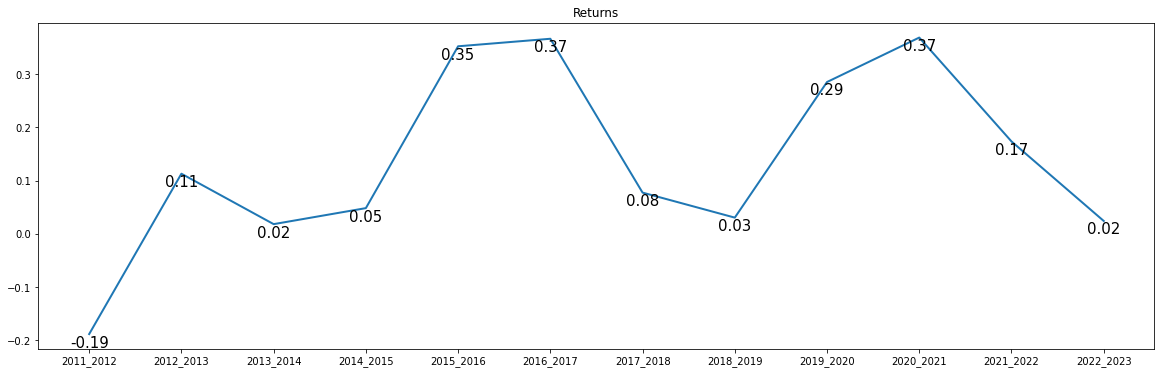

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_weighted.index, df_weighted['return'], linewidth=2.0)
for i, y in enumerate(df_weighted['return']):
    #ax.scatter(df_weighted.index, df_weighted['return'], s=10, c='red', marker='o')
    ax.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax.set_title('Returns')
plt.savefig('returns_weighted_2010-2023.jpg', bbox_inches='tight', dpi = 100)
plt.show()

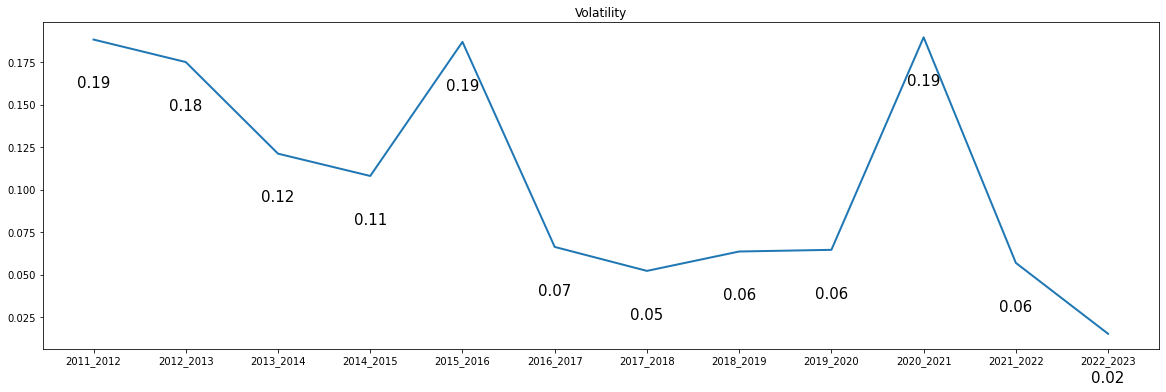

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_weighted.index, df_weighted['volatility'], linewidth=2.0)
for i, y in enumerate(df_weighted['volatility']):
    #ax.scatter(df_weighted.index, df_weighted['return'], s=10, c='red', marker='o')
    ax.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax.set_title('Volatility')
plt.savefig('volatility_weighted_2010-2023.jpg', bbox_inches='tight', dpi = 100)
plt.show()

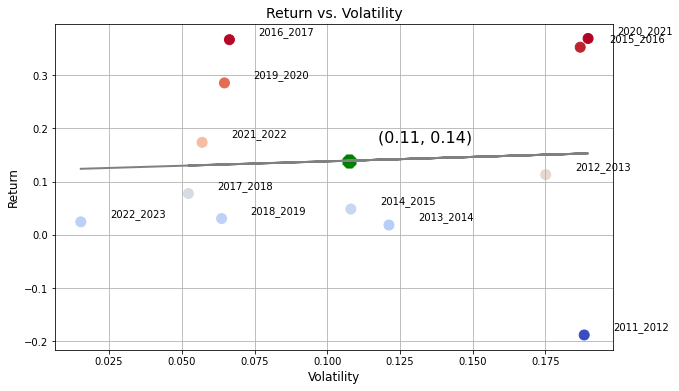

Weighted average return: 0.13913233128007588
Weighted average volatility: 0.10738331583253628


In [14]:
# Create scatter plot with text annotations and trend line
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(df_weighted['volatility'], df_weighted['return'], s=100, c=df_weighted['return'], cmap='coolwarm')
ax.scatter( weighted_volatility,weighted_return, color = 'green',marker = '8', s = 200)
for i, year_range in enumerate(df_weighted.index):
    ax.text(df_weighted['volatility'][i] + 0.01, df_weighted['return'][i] + 0.01, year_range, fontsize=10)
z = np.polyfit(df_weighted['volatility'], df_weighted['return'], 1)
p = np.poly1d(z)
ax.plot(df_weighted['volatility'], p(df_weighted['volatility']), "-", color='gray', linewidth=2)

# Set labels and title
ax.set_xlabel('Volatility', fontsize=12)
ax.set_ylabel('Return', fontsize=12)
ax.set_title('Return vs. Volatility', fontsize=14)

ax.annotate((weighted_volatility.round(2),weighted_return.round(2)), (weighted_volatility+ 0.01, weighted_return+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

# Add colorbar
#fig.colorbar(im, ax=ax)

# Add grid
ax.grid()
plt.savefig('ret vs vol weighted.jpg', bbox_inches='tight', dpi = 100)
plt.show()
print("Weighted average return:", weighted_return)
print("Weighted average volatility:", weighted_volatility)

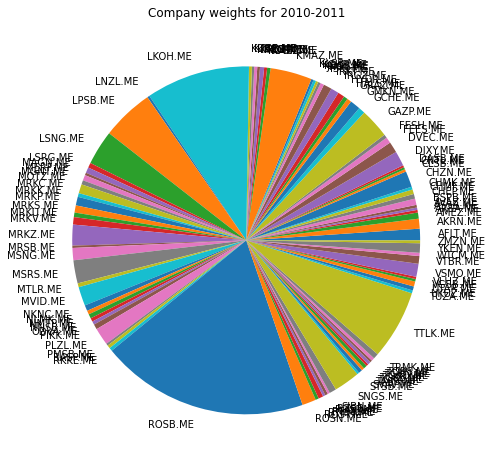

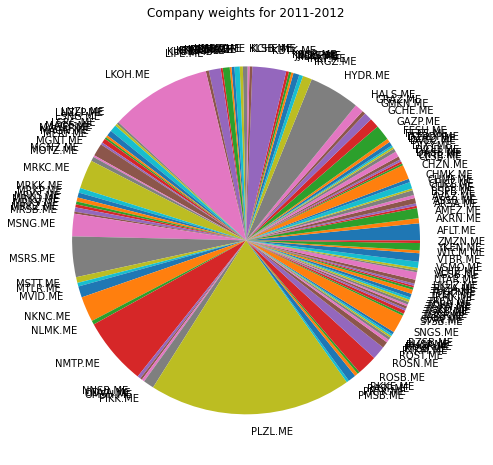

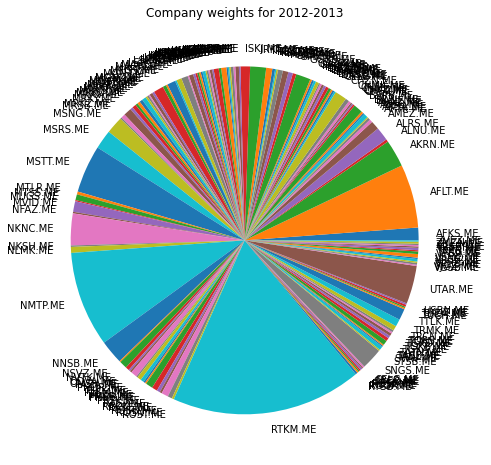

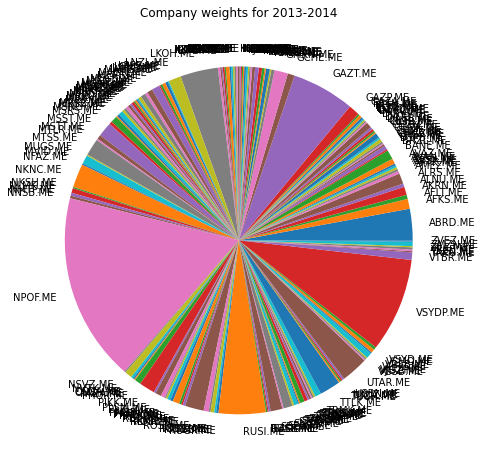

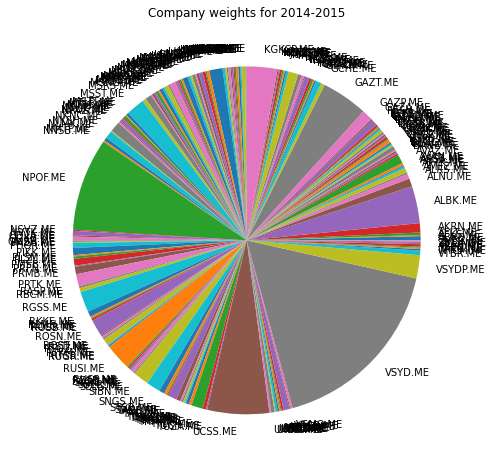

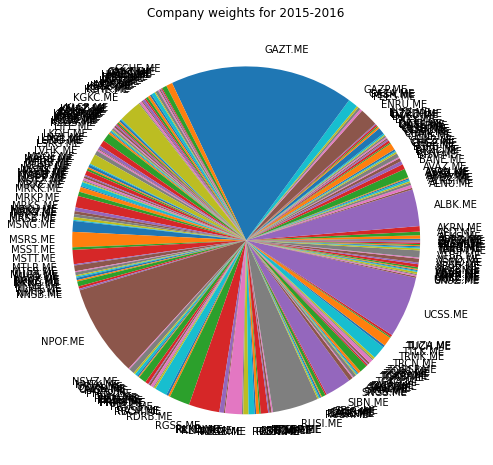

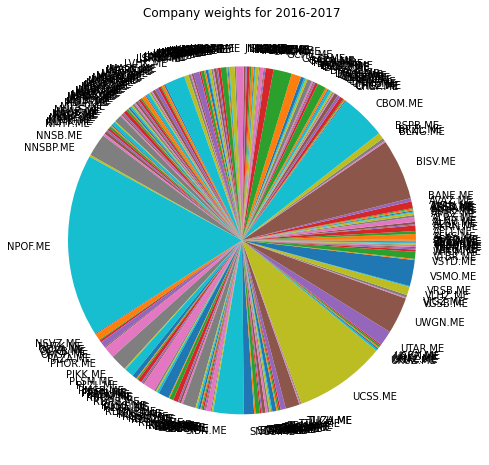

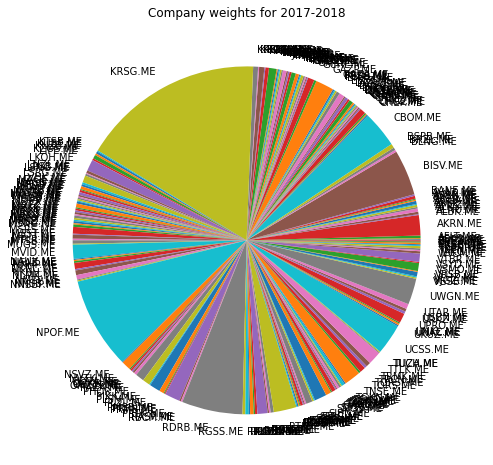

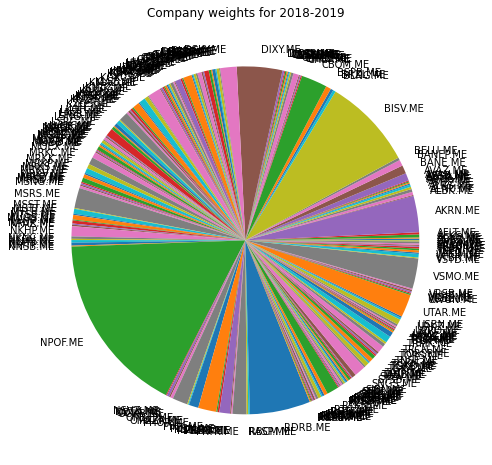

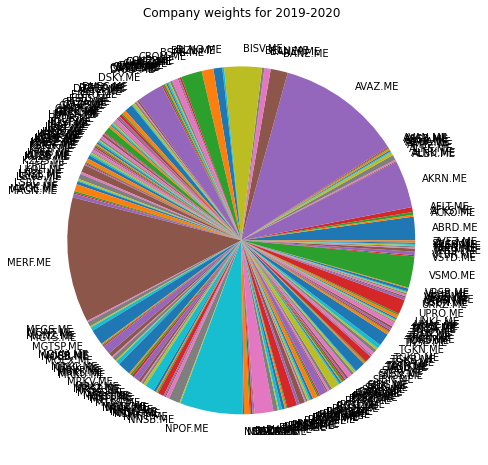

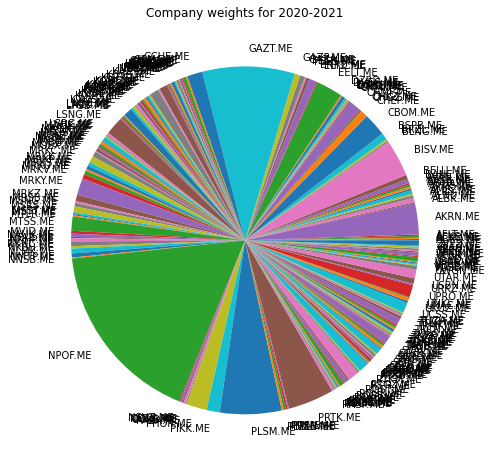

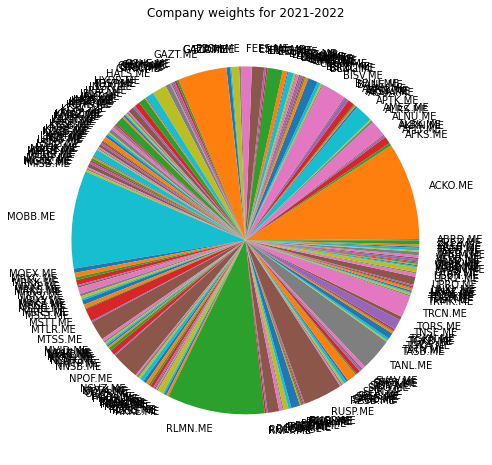

In [62]:
for i in range(1, 13):
    df = globals()[f"information_{i+2009}_{(i+1)+2009}"][1]
    plt.figure(figsize=(8, 8))
    plt.pie(df.values, labels=df.index)
    plt.title(f'Company weights for {i+2009}-{(i+1)+2009}')
    plt.show()

# Вывод по пирогам:  Практически во все года есть 2-3 акции, которые занимают большую часть портфеля и есть остальные акции, веса которых достаточно малы